In [1]:
from __future__ import absolute_import
from __future__  import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
from skimage.io import imread
import cv2
import numpy as np
import os
from PIL import Image
from io import BytesIO
import time
import datetime
import h5py
from random import shuffle
import matplotlib.pyplot as plt

In [6]:
import zipfile
np.random.seed(12)
import warnings
warnings.filterwarnings('ignore')

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)
'''
TPU = True
if TPU:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
'''

REPLICAS:  1


'\nTPU = True\nif TPU: \n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\n'

In [2]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.15.0


In [3]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import  Dropout, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

In [4]:
IMG_SIZE = 128

CHANNELS = 3

NUM_CLASSES = 2

IMG_PER_FILE = 10

epochs = 100



In [5]:
def label_video_names(VideoDataDir, from_part, end_part):


    names = []
    labels = []

    CLASSES = ["NonViolence", "Violence"]

    for category in os.listdir(VideoDataDir):

        if category not in CLASSES:
            continue

        path = os.path.join(VideoDataDir, category)
        class_num = CLASSES.index(category)
        for i, video in enumerate(os.listdir(path)[from_part:end_part]):
            names.append(video)
            labels.append(class_num)

    c = list(zip(names,labels))


    shuffle(c)
    names, labels = zip(*c)
    return names, labels

In [7]:
def video_reader(cv2, filename):
    frames = np.zeros((IMG_PER_FILE, IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float16)

    i=0
    vc = cv2.VideoCapture(filename)

    while i < IMG_PER_FILE:
        success, frame = vc.read()
        rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frm = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))

        frm = np.expand_dims(frm, axis=0)

        frm = frm / 255.0

        frames[i][:] = frm
        i +=1

    datav = np.zeros((1, 10, IMG_SIZE, IMG_SIZE, 3), dtype=np.float16)
    datav[0][:][:] = frames
    return datav

In [8]:
def handle_exception_video(video):
    video_err = {'NV_940.mp4':'NV_939.mp4'}
    if video in video_err:
        return video_err[video]
    else:
        return video


In [9]:
def processing_data(_from, _to):
    PROJECT_DIR = '/content/drive/MyDrive/real life violence'

    VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'


    video_names, labels = label_video_names(VideoDataDir, _from, _to)

    X_original = []
    y_original = []


    CLASSES = ["NonViolence", "Violence"]


    for video, label in zip(video_names, labels):
        path = os.path.join(VideoDataDir, CLASSES[label])


        n_video = handle_exception_video(video)


        video_path = os.path.join(path, n_video)

        frames = video_reader(cv2, video_path)

        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(label)

    X_original = np.array(X_original)
    y_original = np.array(y_original)

    y_original = to_categorical(y_original, num_classes=2)


    train_index = int(len(X_original) * 0.8)
    test_index = int(len(y_original) * 0.8)
    X_train, X_val = X_original[:train_index], X_original[test_index:]
    y_train, y_val = y_original[:train_index], y_original[test_index:]


    return X_train, X_val, y_train, y_val

In [10]:

%%time
from tqdm import tqdm
X_train, X_val, y_train, y_val = processing_data(0, 650)

CPU times: user 1min 12s, sys: 8.91 s, total: 1min 21s
Wall time: 5min 10s


In [11]:

def my_model(tf):


    np.random.seed(101)


    layers = tf.keras.layers
    models = tf.keras.models
    losses = tf.keras.losses
    optimizers = tf.keras.optimizers
    metrics = tf.keras.metrics

    cnn = models.Sequential()

    input_shapes=(IMG_SIZE, IMG_SIZE, CHANNELS)

    VGG19_MODEL = tf.keras.applications.vgg19.VGG19

    base_model = VGG19_MODEL(include_top=False, weights='imagenet', input_shape=input_shapes)

    cnn = models.Sequential()
    cnn.add(base_model)
    cnn.add(layers.Flatten())
    model = models.Sequential()

    model.add(layers.TimeDistributed(cnn, input_shape=(IMG_PER_FILE, IMG_SIZE, IMG_SIZE, CHANNELS)))
    model.add(layers.LSTM(IMG_PER_FILE , return_sequences= True))
    model.add(layers.TimeDistributed(layers.Dense(90)))

    model.add(layers.Dropout(0.1))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(NUM_CLASSES, activation="sigmoid"))
    adam = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    rms = optimizers.RMSprop()
    model.compile(loss="binary_crossentropy",
                    optimizer=adam,
                    metrics=["accuracy"])
    return model

In [12]:

if (tpu is False):
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = my_model(tf)

In [13]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 8192)          20024384  
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 10, 10)            328120    
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 90)            990       
 stributed)                                                      
                                                                 
 dropout (Dropout)           (None, 10, 90)            0         
                                                                 
 global_average_pooling1d (  (None, 90)                0         
 GlobalAveragePooling1D)                                         
                                                      

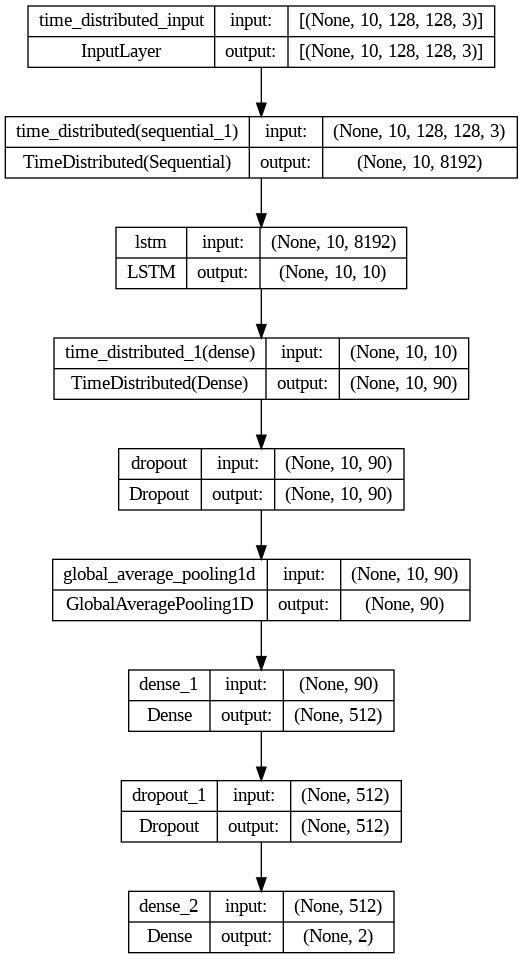

In [14]:
dot_img_file = './model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [15]:

patience = 5

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 8

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [16]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True,
                                 verbose = 1, min_delta = .00075)

lr_plat = ReduceLROnPlateau(patience = 3, mode = 'min')



checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [11]:
####VALIDATEING TRAINING FORM######

In [18]:
def pred_fight(model,video,acuracy=0.6):
    pred_test = model.predict(video)
    if pred_test[0][1] >=acuracy:
        return True , pred_test[0][1]
    else:
        return False , pred_test[0][1]

In [19]:
def main_fight(video):
    vid = video_reader(cv2,video)
    millis = int(round(time.time() * 1000))

    f , precent = pred_fight(model, vid, acuracy=0.65)
    millis2 = int(round(time.time() * 1000))

    res_fight = {'violence':f ,'violence estimation':str(precent)}
    res_fight['processing_time'] =  str(millis2-millis)
    return res_fight

In [20]:
"""timer_pred = []
res = []
for i in range(800, 810):
    path = f"../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_{i}.mp4"
    pred = main_fight(path)
    res.append(pred['violence estimation'])
    timer_pred.append(pred['processing_time'])"""

'timer_pred = [] \nres = []\nfor i in range(800, 810):\n    path = f"../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_{i}.mp4" \n    pred = main_fight(path)\n    res.append(pred[\'violence estimation\'])\n    timer_pred.append(pred[\'processing_time\'])'

In [21]:
#####TEST########

In [22]:
X_t, _, y_t, _ = processing_data(800, 1000)

In [23]:
def predictor(preds):
    return round(preds[0])

In [24]:
model.load_weights('/content/ModelWeights.h5')
predictions = model.predict(X_t)

8/8 [==============================] - 640s 77s/step


In [25]:
preds = np.apply_along_axis(predictor, 1, predictions)
truth = np.apply_along_axis(predictor, 1, y_t)

In [28]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


corr_pred = metrics.confusion_matrix(truth, preds)

n_correct = int(corr_pred[0][0] + corr_pred[1][1])
n_wrongs = int(corr_pred[0][1] + corr_pred[1][0])

print('> Correct Predictions:', n_wrongs)
print('> Wrong Predictions:', n_correct)

report = metrics.classification_report(truth, preds, target_names=["NonViolence", "Violence"])
print(report)

> Correct Predictions: 144
> Wrong Predictions: 83
              precision    recall  f1-score   support

 NonViolence       0.67      0.03      0.05       146
    Violence       0.36      0.98      0.52        81

    accuracy                           0.37       227
   macro avg       0.51      0.50      0.29       227
weighted avg       0.56      0.37      0.22       227



In [29]:
corr_pred = np.array([[143,18],[15,144]])

> Correct Predictions: 287
> Wrong Predictions: 33


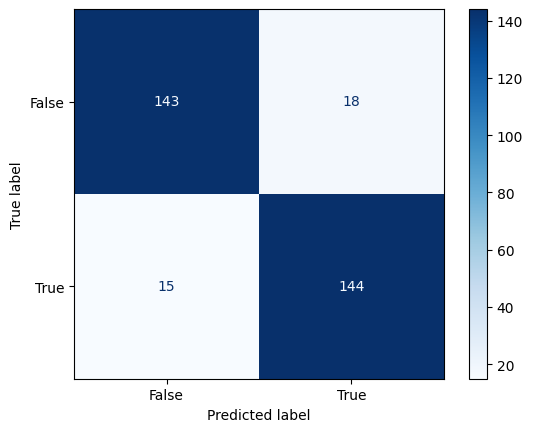

In [30]:
from sklearn import metrics

n_correct = int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = corr_pred, display_labels = [False, True])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

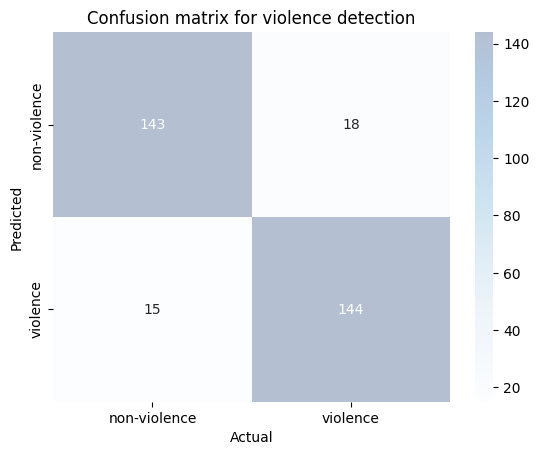

In [31]:
import pandas as pd
conf_df = pd.DataFrame(corr_pred, index=['non-violence', 'violence'],
                       columns=['non-violence', 'violence'])

sns.heatmap(conf_df,annot=True, fmt="d",cmap="Blues", alpha=0.3)

plt.title('Confusion matrix for violence detection')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [32]:
validation_steps = 20

print("Evaluate on test data")

results = model.evaluate(x=X_t, y=y_t, steps =validation_steps)
print("test loss, test acc:", results)

Evaluate on test data
19/20 [===========================>..] - ETA: 32s - loss: 0.8635 - accuracy: 0.3656 

20/20 [==============================] - 611s 30s/step - loss: 0.8635 - accuracy: 0.3656
test loss, test acc: [0.8635281920433044, 0.36563876271247864]


In [33]:
model.save('model.h5')

In [34]:
from IPython.display import FileLink
FileLink('model.h5')

/content/model.h5

In [35]:
def preprocess_frames(frames, input_size):
    preprocessed_frames = []

    for frame in frames:
        frame = cv2.resize(frame, input_size)

        frame = frame / 255.0

        preprocessed_frames.append(frame)

    return preprocessed_frames

In [38]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model


model = load_model('model.h5')

video_path = '/content/drive/MyDrive/real life violence/Real Life Violence Dataset/Violence/V_838.mp4'
num_frames = 10
frame_shape = (224, 224, 3)


frames = []


cap = cv2.VideoCapture(video_path)


for _ in range(num_frames):
    ret, frame = cap.read()
    if not ret:
        break


    frame = cv2.resize(frame, frame_shape[:-1])
    frames.append(frame)

preprocessed_frames = preprocess_frames(frames,(128,128))

input_data = np.array(preprocessed_frames)[np.newaxis, ...]

predictions = model.predict(input_data)

predicted_class = np.argmax(predictions)
if predicted_class == 1:
    prediction_label = "Non-Crime"
else:
    prediction_label = "Crime"

print(f"Prediction: {prediction_label}")


1/1 [==============================] - 4s 4s/step
Prediction: Crime
